In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pyclustertend import vat
from pyclustertend import ivat


In [2]:
hap_df = pd.read_csv("data/world_happiness_rankings_2022.csv")
hap_df.head()

,RANK,Country,Happiness score,Whisker-high,Whisker-low,Dystopia (1.83) + residual,Explained by: GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption
0,1,Finland,7.821,7.886,7.756,2.518,1.892,1.258,0.775,0.736,0.109,0.534
1,2,Denmark,7.636,7.710,7.563,2.226,1.953,1.243,0.777,0.719,0.188,0.532
2,3,Iceland,7.557,7.651,7.464,2.320,1.936,1.320,0.803,0.718,0.270,0.191
3,4,Switzerland,7.512,7.586,7.437,2.153,2.026,1.226,0.822,0.677,0.147,0.461
4,5,Netherlands,7.415,7.471,7.359,2.137,1.945,1.206,0.787,0.651,0.271,0.419


In [3]:
ranking_df = hap_df[['RANK', 'Country']]
metrics_df = hap_df.drop(['RANK', 'Country'], axis=1)


In [4]:
# Standardize Dataset
metrics_df = StandardScaler().fit_transform(metrics_df)

# apply 2D PCA 
pca_2 = PCA(n_components=2)
pca_2_data = pca_2.fit_transform(metrics_df)
pca_2_df = pd.DataFrame(data=pca_2_data, columns=['PC1', 'PC2'])
pca_2_ranking_df = pd.concat([ranking_df, pca_2_df], axis=1)
pca_2_ranking_df.head()

,RANK,Country,PC1,PC2
0,1,Finland,-4.966929,-0.421283
1,2,Denmark,-4.697100,-0.285749
2,3,Iceland,-4.234076,-1.113467
3,4,Switzerland,-4.463696,0.126756
4,5,Netherlands,-4.092789,-0.592264


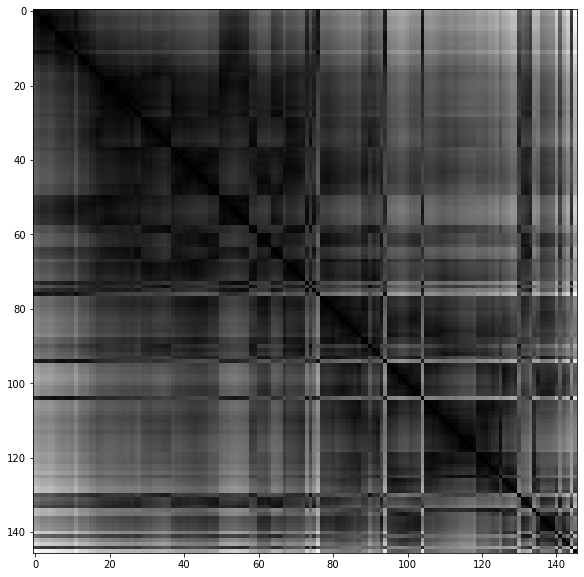

In [5]:
vat(pca_2_data)

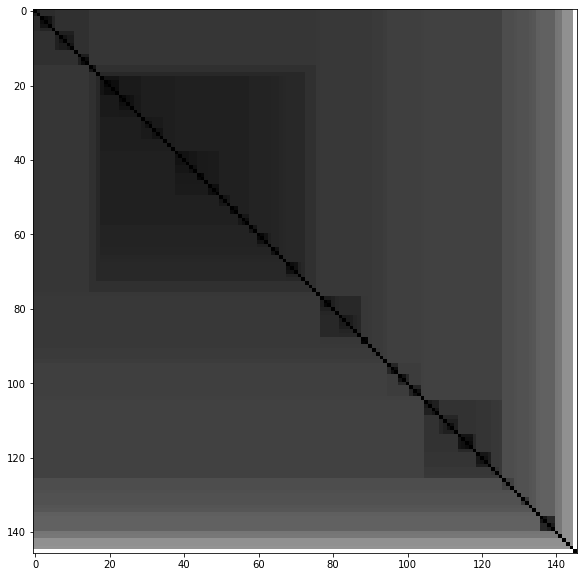

In [6]:
ivat(pca_2_data)

In [7]:
# apply 3D PCA 
pca_3 = PCA(n_components=3)
pca_3_data = pca_3.fit_transform(metrics_df)
pca_3_df = pd.DataFrame(data=pca_3_data, columns=['PC1', 'PC2', 'PC3'])
pca_3_ranking_df = pd.concat([ranking_df, pca_3_df], axis=1)
pca_3_ranking_df.head()

,RANK,Country,PC1,PC2,PC3
0,1,Finland,-4.966929,-0.421283,0.555072
1,2,Denmark,-4.697100,-0.285749,1.383118
2,3,Iceland,-4.234076,-1.113467,0.648670
3,4,Switzerland,-4.463696,0.126756,0.707251
4,5,Netherlands,-4.092789,-0.592264,1.576686


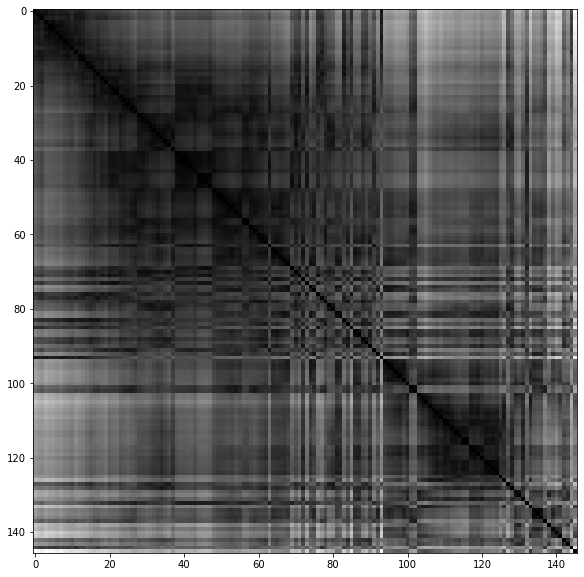

In [8]:
vat(pca_3_df)

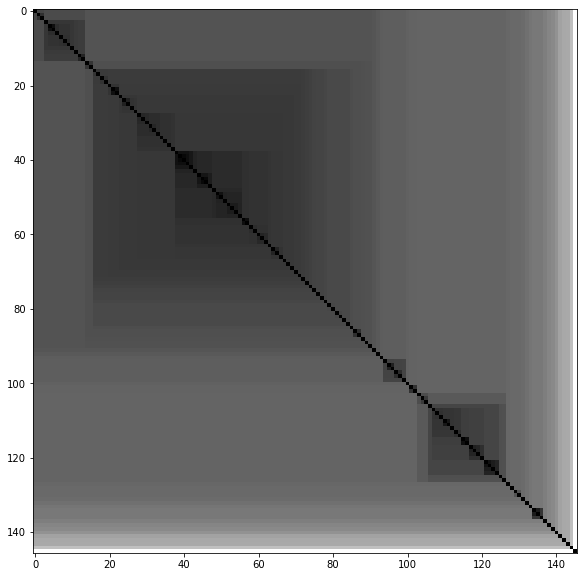

In [9]:
ivat(pca_3_df)